In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from netam import shmoof, noof

In [2]:
train_df, val_df = shmoof.load_shmoof_dataframes("/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv", sample_count=5000)

In [3]:
kmer_length = 5
max_length = 500

train_dataset = shmoof.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
val_dataset = shmoof.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)

print(f"we have {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

we have 3629 training examples and 1371 validation examples


In [4]:
model = shmoof.SHMoofModel(train_dataset)
burrito = shmoof.SHMoofBurrito(train_dataset, val_dataset, model, l2_regularization_coeff=1e-6)
print("starting training...")
losses = burrito.train(epochs=3)
burrito.write_shmoof_output("_ignore/reshmoof")

starting training...
Epoch [1/3]	 Loss: 0.06200696	 Val Loss: 0.06894157
Epoch [2/3]	 Loss: 0.05864622	 Val Loss: 0.06876527
Epoch [3/3]	 Loss: 0.05853805	 Val Loss: 0.06877682


In [5]:
model = shmoof.SHMoofModel(train_dataset)
burrito = shmoof.NoofBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.5, l2_regularization_coeff=1e-6)
print("starting training...")
losses = burrito.train(epochs=10)
burrito.write_shmoof_output("_ignore/reshmoof")

starting training...
Epoch [1/10]	 Loss: 0.070235071	 Val Loss: 0.07116344
Epoch [2/10]	 Loss: 0.060150131	 Val Loss: 0.071089036
Epoch [3/10]	 Loss: 0.059687259	 Val Loss: 0.070592118
Epoch [4/10]	 Loss: 0.059116328	 Val Loss: 0.069707473
Epoch [5/10]	 Loss: 0.05857327	 Val Loss: 0.069202681
Epoch [6/10]	 Loss: 0.058280792	 Val Loss: 0.068779966
Epoch [7/10]	 Loss: 0.058002906	 Val Loss: 0.068495447
Epoch [8/10]	 Loss: 0.057803124	 Val Loss: 0.068303603
Epoch [9/10]	 Loss: 0.057694865	 Val Loss: 0.06816163
Epoch [10/10]	 Loss: 0.057630072	 Val Loss: 0.067984999


In [11]:
model = noof.NoofModel(train_dataset, embedding_dim=2, nhead=2, dim_feedforward=512, layer_count=3, dropout=0.1)

# device = pick_device()
# train_dataset.to(device)
# val_dataset.to(device)
# model.to(device)

burrito = shmoof.NoofBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.5, l2_regularization_coeff=1e-6)
print("starting training...")
losses = burrito.train(epochs=10)

starting training...
Epoch [1/10]	 Loss: 0.070800348	 Val Loss: 0.071063969
Epoch [2/10]	 Loss: 0.060193697	 Val Loss: 0.070985438
Epoch [3/10]	 Loss: 0.059854599	 Val Loss: 0.07039659
Epoch [4/10]	 Loss: 0.059216375	 Val Loss: 0.069591591
Epoch [5/10]	 Loss: 0.05870044	 Val Loss: 0.069138162
Epoch [6/10]	 Loss: 0.058306265	 Val Loss: 0.068763405
Epoch [7/10]	 Loss: 0.058020801	 Val Loss: 0.0683754
Epoch [8/10]	 Loss: 0.057785854	 Val Loss: 0.06815289
Epoch [9/10]	 Loss: 0.057672357	 Val Loss: 0.068100702
Epoch [10/10]	 Loss: 0.057600132	 Val Loss: 0.068018151


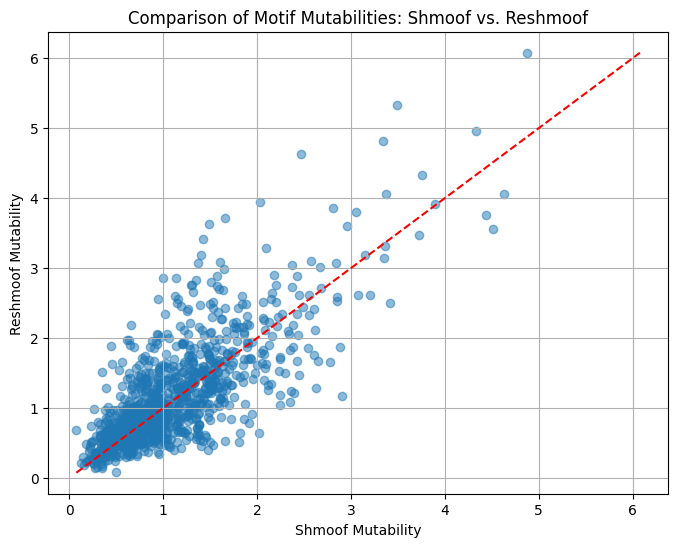

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load motif mutabilities
shmoof_motifs = pd.read_csv('_ignore/original_shmoof/mutabilities_context.tsv', sep='\t')
reshmoof_motifs = pd.read_csv('_ignore/reshmoof/motif_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_motifs = pd.merge(shmoof_motifs, reshmoof_motifs, on='Motif', how='inner', suffixes=('_shmoof', '_reshmoof'))

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_motifs['Mutability_shmoof'], merged_motifs['Mutability_reshmoof'], alpha=0.5)

# Determine bounds for y=x line
min_bound = min(merged_motifs['Mutability_shmoof'].min(), merged_motifs['Mutability_reshmoof'].min())
max_bound = max(merged_motifs['Mutability_shmoof'].max(), merged_motifs['Mutability_reshmoof'].max())

# Add y=x line
plt.plot([min_bound, max_bound], [min_bound, max_bound], 'r--')

plt.xlabel('Shmoof Mutability')
plt.ylabel('Reshmoof Mutability')
plt.title('Comparison of Motif Mutabilities: Shmoof vs. Reshmoof')
plt.grid(True)
plt.show()

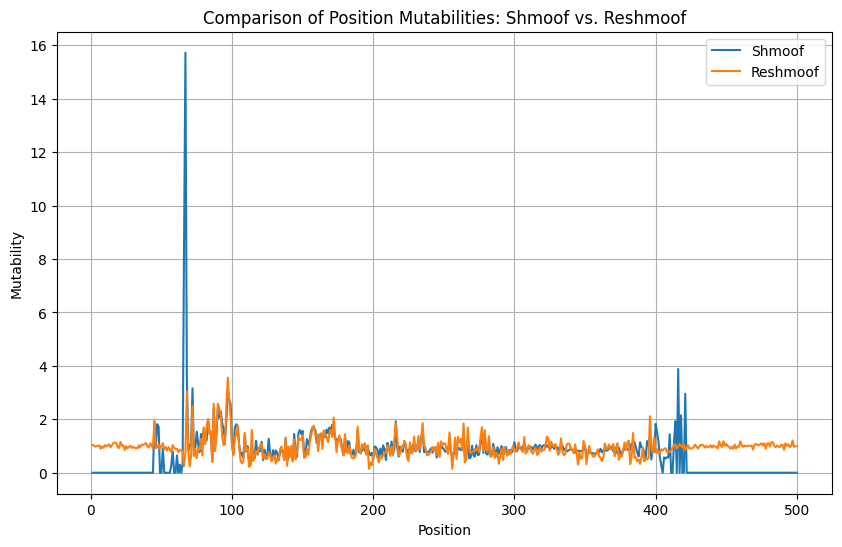

In [7]:
# Load position mutabilities
shmoof_positions = pd.read_csv('_ignore/original_shmoof/mutabilities_position.tsv', sep='\t')
reshmoof_positions = pd.read_csv('_ignore/reshmoof/site_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_positions = pd.merge(shmoof_positions, reshmoof_positions, on='Position', suffixes=('_shmoof', '_reshmoof'))
merged_positions.sort_values(by='Position', inplace=True)

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(merged_positions['Position'], merged_positions['Mutability_shmoof'], label='Shmoof')
plt.plot(merged_positions['Position'], merged_positions['Mutability_reshmoof'], label='Reshmoof')
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.title('Comparison of Position Mutabilities: Shmoof vs. Reshmoof')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
regularization_coeffs = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]

results = []

for coeff in regularization_coeffs:
    print(f"Training with regularization coefficient {coeff}")
    model = shmoof.SHMoofModel(train_dataset)
    burrito = noof.NoofBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=1e-6)
    loss_history = burrito.train(epochs=20)
    final_training_loss = loss_history['training_losses'].iloc[-1]
    final_validation_loss = loss_history['validation_losses'].iloc[-1]

    results.append({
        'Regularization': coeff,
        'Final_Training_Loss': final_training_loss,
        'Final_Validation_Loss': final_validation_loss
    })

regularization_results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Training_Loss'], label='Training Loss', marker='o')
plt.plot(regularization_results_df['Regularization'], regularization_results_df['Final_Validation_Loss'], label='Validation Loss', marker='x')

plt.xscale('log')
plt.xlabel('Regularization Coefficient')
plt.ylabel('Loss')
plt.title('Effect of L2 Regularization on Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Training with regularization coefficient 0


AttributeError: module 'netam.noof' has no attribute 'NoofBurrito'